In [56]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fake-news-classification/WELFake_Dataset.csv


In [57]:
import re 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
pd.set_option("display.max_rows", None,"display.max_columns", None)
warnings.simplefilter(action='ignore')
plt.style.use('seaborn')
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
try:
    from xgboost import XGBClassifier
except:
    !pip install xgboost
    from xgboost import XGBClassifier

from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
try:
    from mlxtend.plotting import plot_confusion_matrix
except:
    !pip install mlxtend
    from mlxtend.plotting import plot_confusion_matrix
    
from IPython.display import Image
try:
    import stylecloud
except:
    !pip install stylecloud
    import stylecloud

In [58]:
df=pd.read_csv("/kaggle/input/fake-news-classification/WELFake_Dataset.csv")
df.head()

,Unnamed: 0,title,text,label
0,0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
1,1,NaN,Did they post their votes for Hillary already?,1
2,2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1
3,3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0
4,4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1


In [59]:
df.shape

(72134, 4)

In [60]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72134 entries, 0 to 72133
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  72134 non-null  int64 
 1   title       71576 non-null  object
 2   text        72095 non-null  object
 3   label       72134 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 2.2+ MB


In [61]:
df.drop(columns=['Unnamed: 0'],inplace=True)

In [62]:
df.dropna(inplace=True)

In [63]:
df.duplicated().sum()

8416

In [64]:
df.drop_duplicates(inplace=True)

In [65]:
df.shape

(63121, 3)

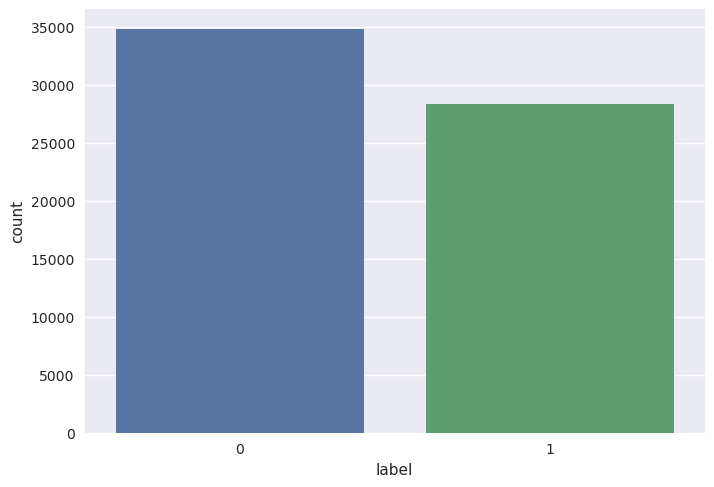

In [66]:
chart=sns.countplot(x='label',data=df)

In [67]:
df['txt']=df['title']+' '+df['text']
df.drop(columns=['title','text'],inplace=True)

In [68]:
df.head()

,label,txt
0,1,LAW ENFORCEMENT ON HIGH ALERT Following Threat...
2,1,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...
3,0,"Bobby Jindal, raised Hindu, uses story of Chri..."
4,1,SATAN 2: Russia unvelis an image of its terrif...
5,1,About Time! Christian Group Sues Amazon and SP...


In [69]:
new_df=df.sample(200).reset_index(drop='index')
new_df.head()

,label,txt
0,1,BREAKING: FBI Has Been Compromised! Look What ...
1,1,Jane Goodall Says Donald Trump Reminds Her Of...
2,1,IV Varitas Mail with questions or comments abo...
3,1,Comment on Neoliberalism’s Border Guard by cra...
4,0,Donald Trump Adjusts His Complaints About Deba...


In [70]:
new_df.shape

(200, 2)

In [71]:
import nltk
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

ps = PorterStemmer()

In [72]:
def process_text(text):
    # Remove punctuation
    text  = re.sub(r'[^a-zA-Z]',' ',text)
    nopunc = [char for char in text if char not in string.punctuation]
    nopunc = ''.join(nopunc)
    
    # Remove stopwords
    clean_words = [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]
    
    # Stemming words
    stemmed_words = [ps.stem(word) for word in clean_words]
    
    return " ".join(stemmed_words)

In [73]:
new_df['txt'] = new_df['txt'].apply(process_text)

In [74]:
new_df['txt'].head()

0    break fbi compromis look hillari sabotag new i...
1    jane goodal say donald trump remind chimpanze ...
2    IV varita mail question comment site godlik pr...
3    comment neoliber border guard craazyboy outi p...
4    donald trump adjust complaint debat microphon ...
Name: txt, dtype: object

In [75]:
new_df.head()

,label,txt
0,1,break fbi compromis look hillari sabotag new i...
1,1,jane goodal say donald trump remind chimpanze ...
2,1,IV varita mail question comment site godlik pr...
3,1,comment neoliber border guard craazyboy outi p...
4,0,donald trump adjust complaint debat microphon ...


In [76]:
x = new_df['txt']
y = new_df['label']

In [77]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.5, random_state=24, shuffle =True)
x_train.shape,x_test.shape,y_train.shape,y_test.shape

((100,), (100,), (100,), (100,))

In [78]:
my_tfidf = TfidfVectorizer()
x_train = my_tfidf.fit_transform(x_train).toarray()
x_test = my_tfidf.transform(x_test).toarray()

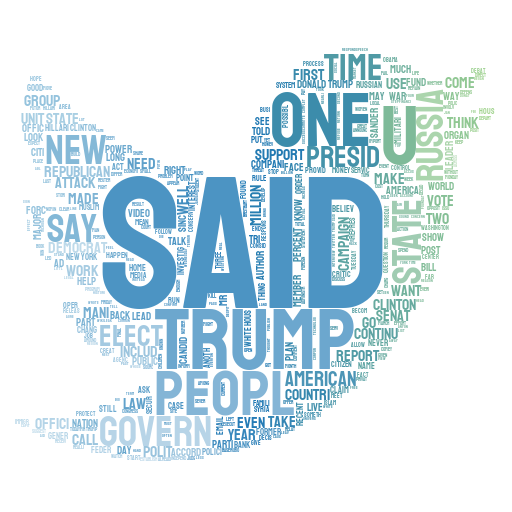

In [79]:
stylecloud.gen_stylecloud(text=" ".join(new_df['txt']), 
                          icon_name='fab fa-twitter',
                          palette='colorbrewer.qualitative.Paired_3', 
                          background_color='white',
                          gradient='horizontal')
Image('stylecloud.png')

In [88]:
train_scores = []
test_scores = []
CV=[]

def algorithm(model):
    # Training model
    model.fit(x_train,y_train)
            
    # score of train set
    train_model_score = model.score(x_train,y_train)
    train_scores.append(round(train_model_score,2))
    y_pred_train=model.predict(x_train)
    
    # score of test set
    test_model_score = model.score(x_test,y_test)
    test_scores.append(round(test_model_score,2))
    y_pred_test=model.predict(x_test)
    
    # train set using Cross validation
    cross_val = cross_val_score(model ,x_train ,y_train ,cv=10)
    cv_mean = cross_val.mean()
    CV.append(round(cv_mean,2))
    
    print("Train score :",round(train_model_score,2))
    print("Test score :",round(test_model_score,2))
    print("Train CV mean :",round(cv_mean,2))
    
    df_model = pd.DataFrame(classification_report(y_pred_test,y_test, digits=2,output_dict=True)).T
    df_model['support'] = df_model.support.apply(int)
    df_model.style.background_gradient(cmap='viridis',subset=pd.IndexSlice['0':'9', :'f1-score'])
    display(df_model)
    
    print("\n----------------------Confusion Matrix---------------------- \n")
    conf_mat = confusion_matrix(y_test, y_pred_test)
    plot_confusion_matrix(conf_mat,
                      show_normed=True, colorbar=True,
                      class_names=['Fake', 'Real'])
    plt.show()

Train score : 1.0
Test score : 0.53
Train CV mean : 0.58


,precision,recall,f1-score,support
0,0.647059,0.532258,0.584071,62
1,0.408163,0.526316,0.459770,38
accuracy,0.530000,0.530000,0.530000,0
macro avg,0.527611,0.529287,0.521920,100
weighted avg,0.556279,0.530000,0.536837,100



----------------------Confusion Matrix---------------------- 



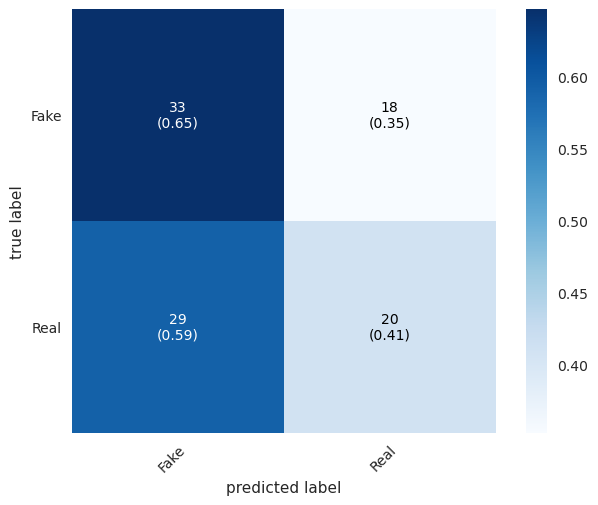

In [89]:
gnv=GaussianNB()
algorithm(gnv)

Train score : 1.0
Test score : 0.73
Train CV mean : 0.74


,precision,recall,f1-score,support
0,0.882353,0.681818,0.769231,66
1,0.571429,0.823529,0.674699,34
accuracy,0.730000,0.730000,0.730000,0
macro avg,0.726891,0.752674,0.721965,100
weighted avg,0.776639,0.730000,0.737090,100



----------------------Confusion Matrix---------------------- 



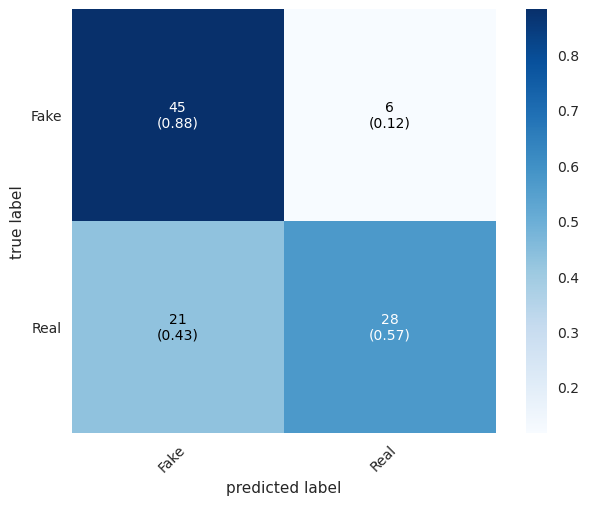

In [82]:
mlp=MLPClassifier()
algorithm(mlp)

Train score : 1.0
Test score : 0.82
Train CV mean : 0.81


,precision,recall,f1-score,support
0,0.960784,0.753846,0.844828,65
1,0.673469,0.942857,0.785714,35
accuracy,0.820000,0.820000,0.820000,0
macro avg,0.817127,0.848352,0.815271,100
weighted avg,0.860224,0.820000,0.824138,100



----------------------Confusion Matrix---------------------- 



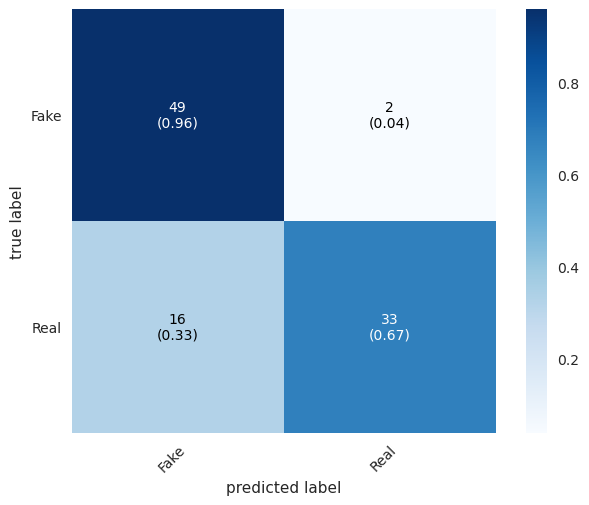

In [83]:
rf=RandomForestClassifier()
algorithm(rf)

Train score : 0.9
Test score : 0.57
Train CV mean : 0.65


,precision,recall,f1-score,support
0,0.980392,0.543478,0.699301,92
1,0.142857,0.875000,0.245614,8
accuracy,0.570000,0.570000,0.570000,0
macro avg,0.561625,0.709239,0.472457,100
weighted avg,0.913389,0.570000,0.663006,100



----------------------Confusion Matrix---------------------- 



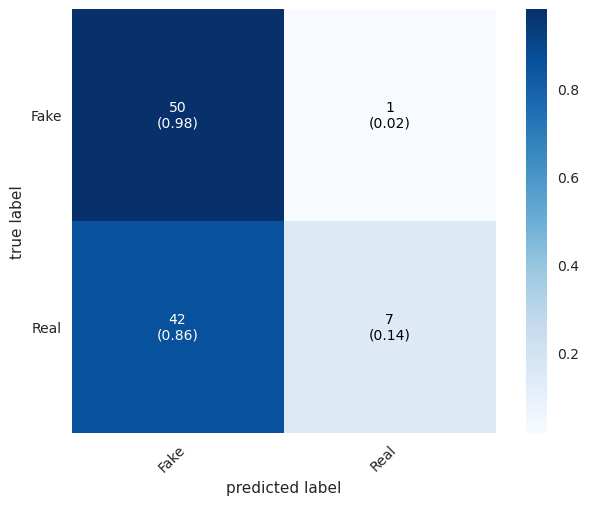

In [84]:
bnv=BernoulliNB()
algorithm(bnv)

Train score : 1.0
Test score : 0.87
Train CV mean : 0.81


,precision,recall,f1-score,support
0,0.862745,0.88,0.871287,50
1,0.877551,0.86,0.868687,50
accuracy,0.870000,0.87,0.870000,0
macro avg,0.870148,0.87,0.869987,100
weighted avg,0.870148,0.87,0.869987,100



----------------------Confusion Matrix---------------------- 



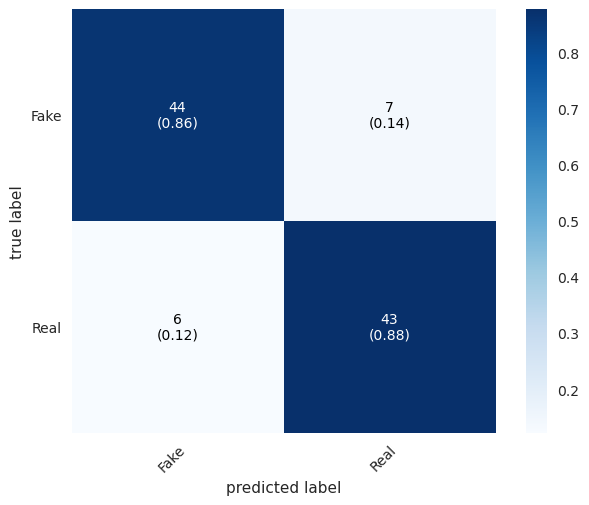

In [85]:
xgb=XGBClassifier()
algorithm(xgb)